In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 1. preprocessing data
# 2. bulid model
# 2.1 encoder
# 2.2 attention
# 2.3 decoder
# 2.4 loss & optimizer
# 2.5 train
# 3. evalutation
# 3.1 given sentence, return translated results
# 3.2 visualize results (attention)

In [3]:
en_spa_file_path = './data_span_en/spa.txt'

import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

en_sentence = 'Then   what.'
sp_sentence = '¿Entonces qué?'
print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

Then   what.
¿Entonces que?


In [4]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    #标点符号前后加空格
    s = re.sub(r'([?.!,¿])', r' \1 ', s)
    #多余的空格变成一个空格
    s = re.sub(r'[" "]+', " ", s)
    
    # 除了标点符号和字母外都是空格
    s = re.sub(r'[^a-zA-Z?.!,¿]', ' ', s)
    #去掉前后空格
    s = s.rstrip().strip()
    
    s = '<start> ' + s + ' <end>'
    return s

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> then what . <end>
<start> ¿ entonces que ? <end>


In [5]:
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs
    ]
    return zip(*preprocessed_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [8]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:3000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:3000])

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

11 8


In [9]:
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size=0.2)
len(input_train), len(input_eval), len(output_train), len(output_eval)

(2400, 600, 2400, 600)

In [10]:
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d --> %s' % (t, tokenizer.index_word[t]))
            
convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 --> <start>
14 --> no
17 --> se
288 --> nadar
3 --> .
2 --> <end>

1 --> <start>
4 --> i
23 --> can
21 --> t
246 --> swim
3 --> .
2 --> <end>


In [11]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder = True)
    return dataset

batch_size = 64
epochs = 20

train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)

In [12]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)
    print(x)
    print(y)

(64, 11) (64, 8)
tf.Tensor(
[[   1   14 1335    3    2    0    0    0    0    0    0]
 [   1   12  387   11  388    3    2    0    0    0    0]
 [   1  776    8    4    3    2    0    0    0    0    0]
 [   1    5   13   51  185    6    2    0    0    0    0]
 [   1    5   39 1697    6    2    0    0    0    0    0]
 [   1 1013   23  194    3    2    0    0    0    0    0]
 [   1    4   17 1031    3    2    0    0    0    0    0]
 [   1   11  342    3    2    0    0    0    0    0    0]
 [   1  596  597    3    2    0    0    0    0    0    0]
 [   1    5   93  373    6    2    0    0    0    0    0]
 [   1    9   34 1474    3    2    0    0    0    0    0]
 [   1   18   77  659    3    2    0    0    0    0    0]
 [   1   38  806    3    2    0    0    0    0    0    0]
 [   1   10  860    3    2    0    0    0    0    0    0]
 [   1  660 1411    3    2    0    0    0    0    0    0]
 [   1  892    8   29    7    2    0    0    0    0    0]
 [   1  362  980    3    2    0    0    0   

In [13]:
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [14]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
       
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sampel_hidden = encoder(x, sample_hidden)

print(sample_output.shape, sample_hidden.shape)

(64, 11, 1024) (64, 1024)


In [15]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
    
    
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape: (batch_size, units)
        # encoder_outputs.shape: (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        
        # before V: (batch_size, length, units)
        # after V: (batch_size, length, 1)
        score = self.V(tf.nn.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        # shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        # context_vector.shape: (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        
        # context_vector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights

attention_model = BahdanauAttention(units = 10)
attention_results, attention_weights = attention_model(sampel_hidden, sample_output)

print(attention_results.shape, attention_weights.shape)

(64, 1024) (64, 11, 1)


In [16]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
    
    
    def call(self, x, hidden, encoding_outputs):
        # context_vector.shape: (batch_size, units)
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)
        
        # before embedding: x.shape: (batch_size, 1)
        # after embedding: x.shape: (batch_size, 1, embedding_units)
        x = self.embedding(x)
        
        combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        # output.shape: (batch_size, 1, decoding_units)
        # state.shape: (batch_size, decoding_units)
        output, state = self.gru(combined_x)
        
        #output.shape: (batch_size, vocab_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.fc(output)
        
        return output, state, attention_weights
    
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)
outputs = decoder(tf.random.uniform((batch_size, 1)),
                 sampel_hidden,
                 sample_output)

decoder_ouput, decoder_hidden, decoder_aw = outputs

print(decoder_ouput.shape, decoder_hidden.shape, decoder_aw.shape)

(64, 918) (64, 1024) (64, 11, 1)


In [17]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [18]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
    
        decoding_hidden = encoding_hidden
    
        # eg.: <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am
        # 3. am -> here
        # 4. here -> <end>
        for t in range(0, targ.shape[1] - 1):
            decoding_input = tf.expand_dims(targ[:, t], 1)

            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t+1], predictions)
    
    batch_loss = loss / int(targ.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss


In [19]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
        
        print('Time take for 1 epoch {} sec\n'.format(time.time() - start))
        

Epoch 1 Batch 0 Loss 0.4913
Epoch 1 Loss 0.0107
Time take for 1 epoch 21.633755922317505 sec

Epoch 1 Loss 0.0215
Time take for 1 epoch 23.870332956314087 sec

Epoch 1 Loss 0.0324
Time take for 1 epoch 25.769220113754272 sec

Epoch 1 Loss 0.0424
Time take for 1 epoch 28.022496938705444 sec

Epoch 1 Loss 0.0506
Time take for 1 epoch 29.9185049533844 sec

Epoch 1 Loss 0.0633
Time take for 1 epoch 31.846547842025757 sec

Epoch 1 Loss 0.0715
Time take for 1 epoch 33.794620990753174 sec

Epoch 1 Loss 0.0789
Time take for 1 epoch 35.62268900871277 sec

Epoch 1 Loss 0.0866
Time take for 1 epoch 37.650452852249146 sec

Epoch 1 Loss 0.0949
Time take for 1 epoch 39.72517490386963 sec

Epoch 1 Loss 0.1029
Time take for 1 epoch 41.656322956085205 sec

Epoch 1 Loss 0.1106
Time take for 1 epoch 43.74341082572937 sec

Epoch 1 Loss 0.1177
Time take for 1 epoch 45.740249156951904 sec

Epoch 1 Loss 0.1247
Time take for 1 epoch 48.10359001159668 sec

Epoch 1 Loss 0.1318
Time take for 1 epoch 50.400124788

Epoch 3 Loss 0.1522
Time take for 1 epoch 64.94127082824707 sec

Epoch 3 Loss 0.1564
Time take for 1 epoch 66.8860878944397 sec

Epoch 3 Loss 0.1607
Time take for 1 epoch 68.69337296485901 sec

Epoch 3 Loss 0.1650
Time take for 1 epoch 70.6316590309143 sec

Epoch 3 Loss 0.1692
Time take for 1 epoch 72.68718600273132 sec

Epoch 3 Loss 0.1733
Time take for 1 epoch 74.85241889953613 sec

Epoch 3 Loss 0.1772
Time take for 1 epoch 76.96235489845276 sec

Epoch 3 Loss 0.1814
Time take for 1 epoch 79.25274085998535 sec

Epoch 3 Loss 0.1856
Time take for 1 epoch 81.29747796058655 sec

Epoch 3 Loss 0.1896
Time take for 1 epoch 83.7062418460846 sec

Epoch 3 Loss 0.1938
Time take for 1 epoch 85.71363997459412 sec

Epoch 3 Loss 0.1981
Time take for 1 epoch 87.65311074256897 sec

Epoch 3 Loss 0.2023
Time take for 1 epoch 89.72848701477051 sec

Epoch 4 Batch 0 Loss 0.1835
Epoch 4 Loss 0.0040
Time take for 1 epoch 1.8918631076812744 sec

Epoch 4 Loss 0.0081
Time take for 1 epoch 3.739342212677002 sec


Epoch 6 Loss 0.0653
Time take for 1 epoch -8.590319871902466 sec

Epoch 6 Loss 0.0684
Time take for 1 epoch -6.657572984695435 sec

Epoch 6 Loss 0.0715
Time take for 1 epoch -4.838241100311279 sec

Epoch 6 Loss 0.0748
Time take for 1 epoch -2.990694999694824 sec

Epoch 6 Loss 0.0779
Time take for 1 epoch -1.0408358573913574 sec

Epoch 6 Loss 0.0809
Time take for 1 epoch 0.9716479778289795 sec

Epoch 6 Loss 0.0840
Time take for 1 epoch 3.0836589336395264 sec

Epoch 6 Loss 0.0868
Time take for 1 epoch 4.9910829067230225 sec

Epoch 6 Loss 0.0899
Time take for 1 epoch 6.896700143814087 sec

Epoch 6 Loss 0.0929
Time take for 1 epoch 8.844871044158936 sec

Epoch 6 Loss 0.0959
Time take for 1 epoch 10.81589126586914 sec

Epoch 6 Loss 0.0990
Time take for 1 epoch 12.682139158248901 sec

Epoch 6 Loss 0.1023
Time take for 1 epoch 14.71862506866455 sec

Epoch 6 Loss 0.1054
Time take for 1 epoch 16.548646211624146 sec

Epoch 6 Loss 0.1084
Time take for 1 epoch 18.688374042510986 sec

Epoch 6 Loss 

Epoch 9 Loss 0.0171
Time take for 1 epoch 15.581945896148682 sec

Epoch 9 Loss 0.0192
Time take for 1 epoch 17.480068922042847 sec

Epoch 9 Loss 0.0212
Time take for 1 epoch 19.404552936553955 sec

Epoch 9 Loss 0.0233
Time take for 1 epoch 21.292951822280884 sec

Epoch 9 Loss 0.0252
Time take for 1 epoch 23.078701972961426 sec

Epoch 9 Loss 0.0273
Time take for 1 epoch 24.880599975585938 sec

Epoch 9 Loss 0.0294
Time take for 1 epoch 26.7923321723938 sec

Epoch 9 Loss 0.0318
Time take for 1 epoch 28.694087028503418 sec

Epoch 9 Loss 0.0339
Time take for 1 epoch 30.47640085220337 sec

Epoch 9 Loss 0.0360
Time take for 1 epoch 32.35990786552429 sec

Epoch 9 Loss 0.0381
Time take for 1 epoch 34.42905402183533 sec

Epoch 9 Loss 0.0404
Time take for 1 epoch 36.40695786476135 sec

Epoch 9 Loss 0.0426
Time take for 1 epoch 38.330815076828 sec

Epoch 9 Loss 0.0448
Time take for 1 epoch 40.154792070388794 sec

Epoch 9 Loss 0.0470
Time take for 1 epoch 42.109883069992065 sec

Epoch 9 Loss 0.0492

In [30]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen = max_length_input, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    results = ''
#     encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1, units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # eg: <start> -> A
    # A -> B -> C -> D
    
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(decoding_input,
                                                                  decoding_hidden,
                                                                  encoding_outputs)
        # attention_weights.shape: (batch_size, input_length, 1)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape: (batch_size, vocab_size)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + ' '
        
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id], 0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')

    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict = font_dict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = font_dict,)
    
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    print('Input: %s' %(input_sentence))
    print('Predicted translation: %s' %(results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')),
                                       :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: he s not in . <end> 


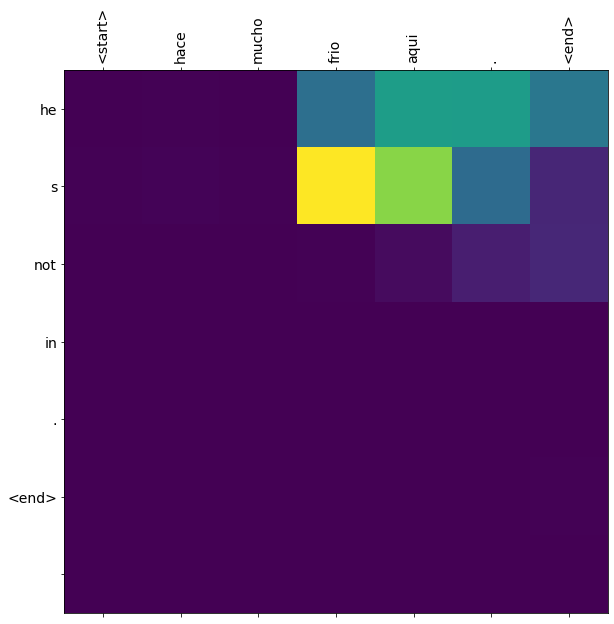

In [31]:
translate(u'Hace mucho frío aquí.')